<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки" data-toc-modified-id="Импортируем-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импортируем библиотеки</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Подберем-параметры-для-LightGBM-с-помощью-Optuna" data-toc-modified-id="Подберем-параметры-для-LightGBM-с-помощью-Optuna-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подберем параметры для LightGBM с помощью Optuna</a></span></li><li><span><a href="#Подберем-параметры-для-DecisionTreeRegressor" data-toc-modified-id="Подберем-параметры-для-DecisionTreeRegressor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подберем параметры для DecisionTreeRegressor</a></span></li><li><span><a href="#Подберем-параметры-для-RandomForestRegressor" data-toc-modified-id="Подберем-параметры-для-RandomForestRegressor-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подберем параметры для RandomForestRegressor</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект по курсу "Временные ряды"

**Описание исследования**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Задачи исследования**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Данные лежат в файле `/datasets/taxi.csv`.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Импортируем библиотеки

In [2]:
!pip install optuna -q
!pip install lightgbm -q
!pip install scikit-learn --upgrade -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import optuna
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

import time
import warnings
warnings.filterwarnings("ignore")

In [4]:
try:
  df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
  df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)
df = df.resample('1H').sum()
display(df.head(5))
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
df.index.is_monotonic_increasing

True

**Вывод**

Загрузили данные из csv-файла, сразу изменив на правильный тип данных в столбце `datetime`. Изменили интервал на один час, так как по задаче нам нужно спрогнозировать количество заказов такси на следующий час. Проверили, что данные находятся в хронологическом порядке.

## Анализ

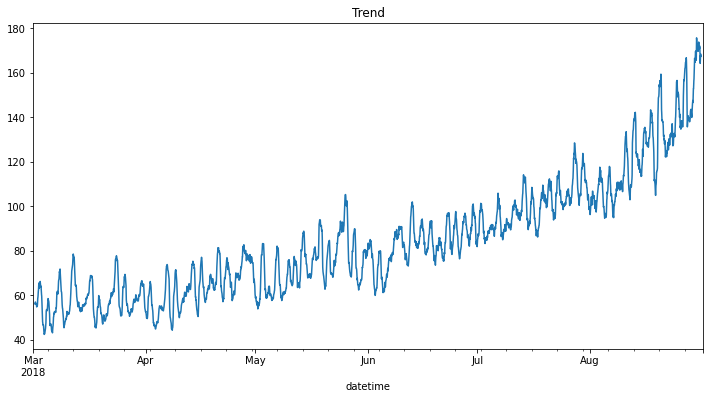

In [6]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 6))
decomposed.trend.plot()
plt.title('Trend')
plt.show()

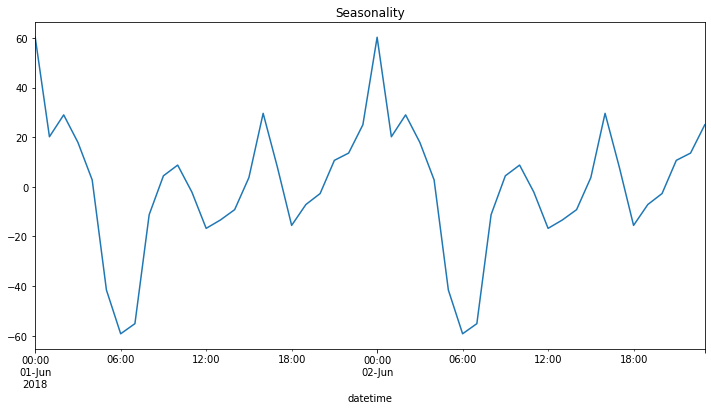

In [7]:
plt.figure(figsize=(12, 6))
decomposed.seasonal['2018-06-01':'2018-06-02'].plot()
plt.title('Seasonality')
plt.show()

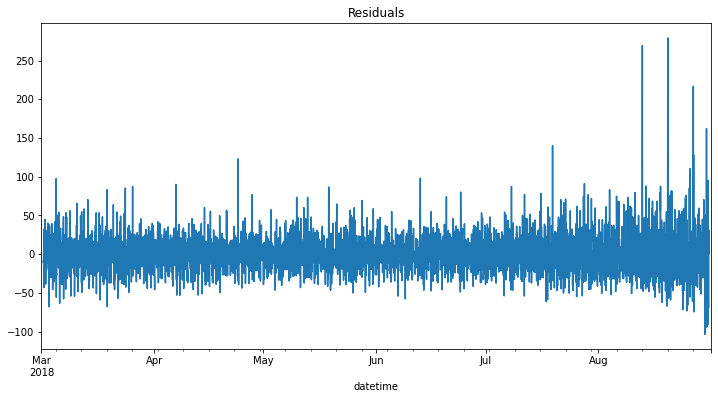

In [8]:
plt.figure(figsize=(12, 6))
decomposed.resid.plot()
plt.title('Residuals')
plt.show()

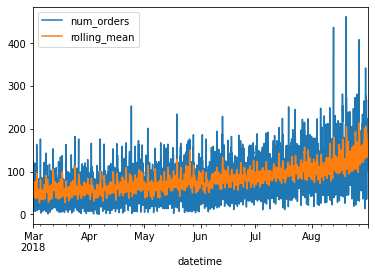

In [9]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()
plt.show()

**Вывод**
- Построили график сезонной составляющей с 1 по 2-ое июня.  Получилось, что ночью высокий спрос на такси.
- По графику с трендом видно, что объем заказов с марта 2018 года объем заказов увеличился

## Подготовка

In [10]:
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
for lag in range(1, 21):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df.head()

,num_orders,rolling_mean,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
X = df.drop(columns='num_orders')
y = df['num_orders']

numerical_features = ['rolling_mean', 'day_of_week', 'hour', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

**Вывод**

- Создали новые признаки: год, месяц, день месяца, день недели, день в году, квартал
- Разделили данные на обучающую и тестовую выборки

## Подберем параметры для LightGBM с помощью Optuna

In [13]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'boosting_type': "gbdt",
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        "verbosity": -1,
        'random_state': 42
    }

    model = lgb.LGBMRegressor(**params, num_threads = 5)
    tscv = TimeSeriesSplit(n_splits=5)
    rmse = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    return -np.mean(rmse)


study = optuna.create_study(study_name="LGBM_study", direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Best parameters and RMSE
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM]

## Подберем параметры для DecisionTreeRegressor

In [21]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features)
])

treeregr_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=42))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(1, 20),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__splitter': ['best', 'random'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]
tscv = TimeSeriesSplit(n_splits=5)
randomized_search = RandomizedSearchCV(
    treeregr_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)
print('Best model:\n\n', randomized_search.best_estimator_)
print ('Best score:', -randomized_search.best_score_)

Best model:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['rolling_mean',
                                                   'day_of_week', 'hour',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=8, min_samples_leaf=7,
                                       min_samples_split=3, random_state=42))])
Best sc

## Подберем параметры для RandomForestRegressor

In [22]:
rf_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestRegressor(random_state=42))
])


rf_grid = [
    {
        'models': [RandomForestRegressor(random_state=42)],
        'models__n_estimators': [100, 120, 150],
        'models__max_depth': [None,1,3,5,7,9],
        'models__max_features': range(1,11),
        'models__min_samples_split':range(2, 10),
        'models__min_samples_leaf':[1,3,5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]
tscv = TimeSeriesSplit(n_splits=5)
rf_search = RandomizedSearchCV(
    rf_final,
    rf_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print('Best model:\n\n', rf_search.best_estimator_)
print ('Best score:', -rf_search.best_score_)

Best model:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['rolling_mean',
                                                   'day_of_week', 'hour',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20'])])),
                ('models',
                 RandomForestRegressor(max_depth=9, max_features=9,
                                       min_samples_leaf=3, min_samples_split=6,
           

Лучший результат на кросс-валидации показала модель LightGBM, с помощью нее сделаем предсказания для тестовой выборки.

In [14]:
final_params = study.best_params

lgb_model = lgb.LGBMRegressor(**final_params)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)
rmse_score = root_mean_squared_error(y_test, lgb_preds)
print(f'RMSE: {rmse_score}')

RMSE: 39.34803589401707


## Общий вывод

- Сделали ресемплирование: увеличили интервал на один час
- Изучили данные: построили графики тренда, сезонности, остатков и скользящего среднего.
- Обучили три разные модели: LightGBM, Random Forest, Decision Tree. С помощью Optuna и RandomizedSearchCV подобрали гиперпараметры.
- Лучший результат показала модель LightGBM.